# Final Project PCD - Tuberculosis Detection

In [30]:
# Import dependencies
import kagglehub
import shutil
import os

import matplotlib.pyplot as plt
import cv2
import numpy as np
from skimage import filters, measure, morphology

# Import data dari Kaggle
file_path = kagglehub.dataset_download("tawsifurrahman/tuberculosis-tb-chest-xray-dataset/versions/3")
extract_path = "./"  # Folder tujuan
shutil.copytree(file_path, extract_path, dirs_exist_ok=True)

# Image Path
source_path = './TB_Chest_Radiography_Database/'
categories = ['Normal', 'Tuberculosis']

Using Colab cache for faster access to the 'tuberculosis-tb-chest-xray-dataset' dataset.


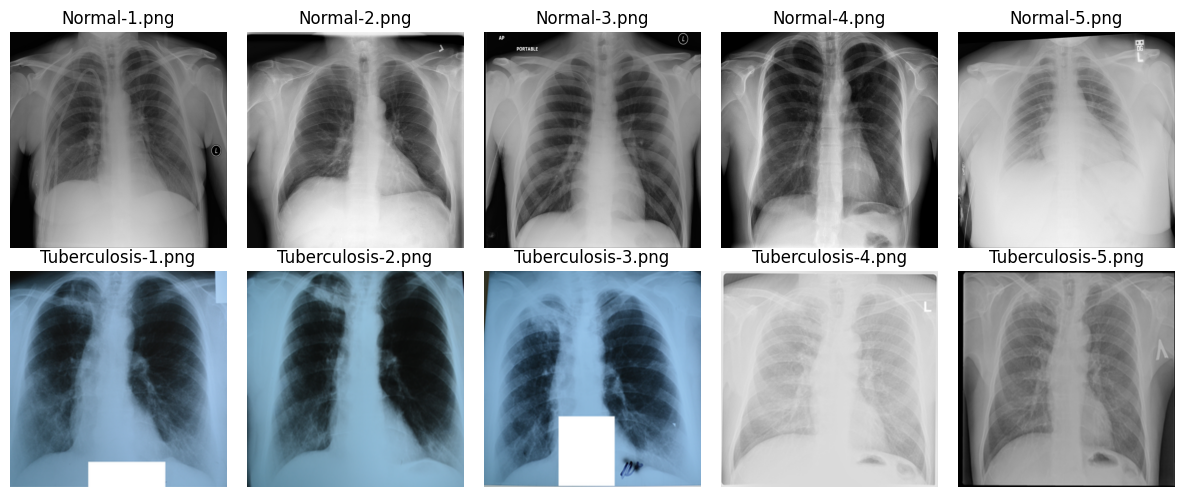

In [2]:
# Preview Images

plt.figure(figsize=(12, 5))

for i, category in enumerate(categories):
    path = os.path.join(source_path, category)
    files = [f"{category}-{n}.png" for n in range(1, 6)]

    for j, file in enumerate(files):
        img_path = os.path.join(path, file)
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        plt.subplot(len(categories), 5, i * 5 + j + 1)
        plt.imshow(img)
        plt.title(file)
        plt.axis('off')

plt.tight_layout()
plt.show()

## Image Enhancement

- Image folder = './TB_Chest_Radiography_Database'
- Output enhancement disimpen di '/enhanced_image' di dalem Image folder

### Proses enhancement:

Raw Image -> Grayscale -> Noise Reduction (Gaussian Blur) -> Contrast Enhancement (CLAHE)

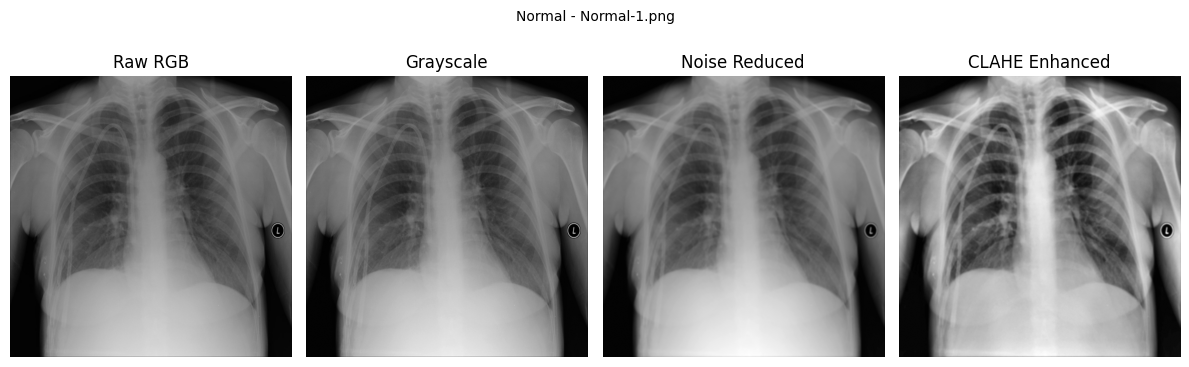

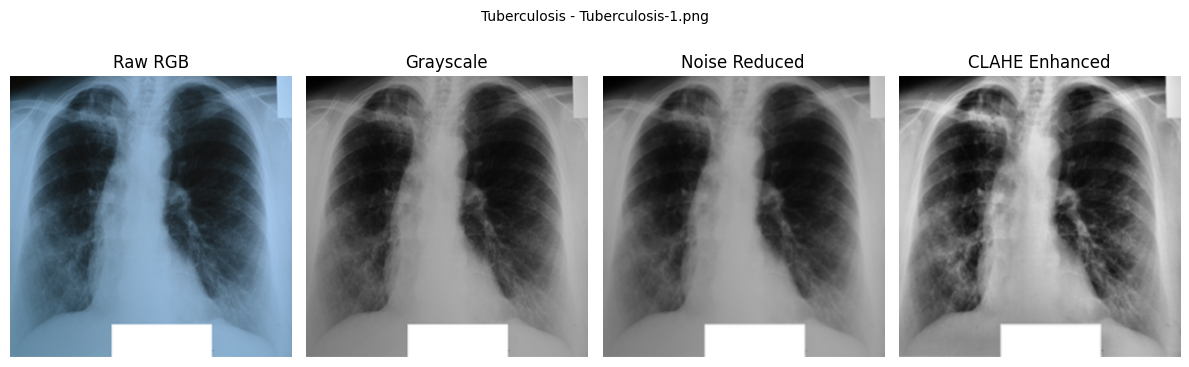

In [3]:
# IMAGE ENHANCEMENT

for category in categories:
    input_dir = os.path.join(source_path, category)
    output_dir = os.path.join('./TB_Chest_Radiography_Database/enhanced_image', category)
    os.makedirs(output_dir, exist_ok=True)

    files = [f for f in os.listdir(input_dir)]
    files.sort(key=lambda x: int(''.join(filter(str.isdigit, x))))  # urutin nomer

    for i, file in enumerate(files):
        img_path = os.path.join(input_dir, file)

        # 1. Raw Image
        img = cv2.imread(img_path)

        # 2. Convert to Grayscale
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

        # 3. Noise Reduction (Gaussian Blur)
        denoised = cv2.GaussianBlur(gray, (5, 5), 0)

        # 4. Contrast Enhancement (CLAHE)
        clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
        enhanced = clahe.apply(denoised)


        # Save gambar
        output_file = os.path.join(output_dir, file)
        cv2.imwrite(output_file, enhanced)

        # Preview hasil

        preview_limit = 1 # limit preview
        if i < preview_limit:
            raw_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            titles = ['Raw RGB', 'Grayscale', 'Noise Reduced', 'CLAHE Enhanced']
            images = [raw_rgb, gray, denoised, enhanced]

            plt.figure(figsize=(12, 4))
            for i in range(4):
                plt.subplot(1, 4, i + 1)
                plt.imshow(images[i], cmap='gray' if i > 0 else None)
                plt.title(titles[i])
                plt.axis('off')
            plt.suptitle(f"{category} - {file}", fontsize=10)
            plt.tight_layout()
            plt.show()

## Lung Region Segmentation

- Input image = '/enhanced_image' di dalem Image folder
- Output segmentation disimpen di '/segmented_image' di dalem Image folder

### Proses segmentation:

Enhanced Image -> Segmentation (Otsu) -> Cleaning (closing, opening, remove small objects) -> Lung Region Identification -> Lung Extraction

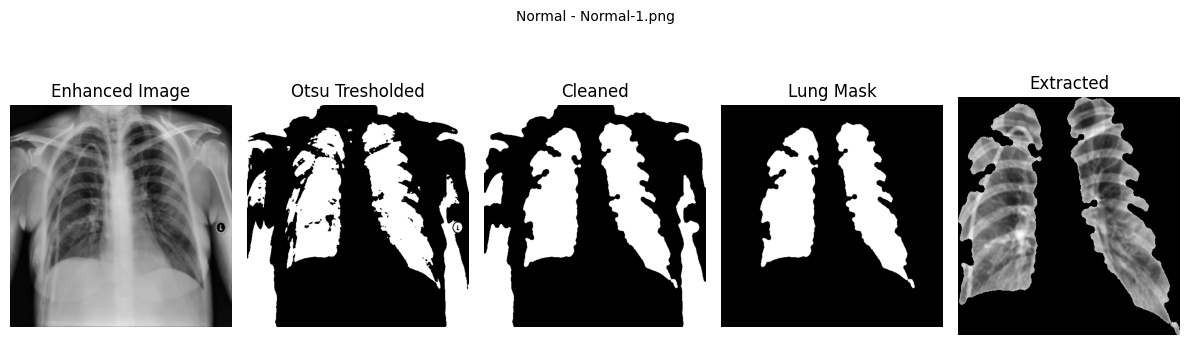

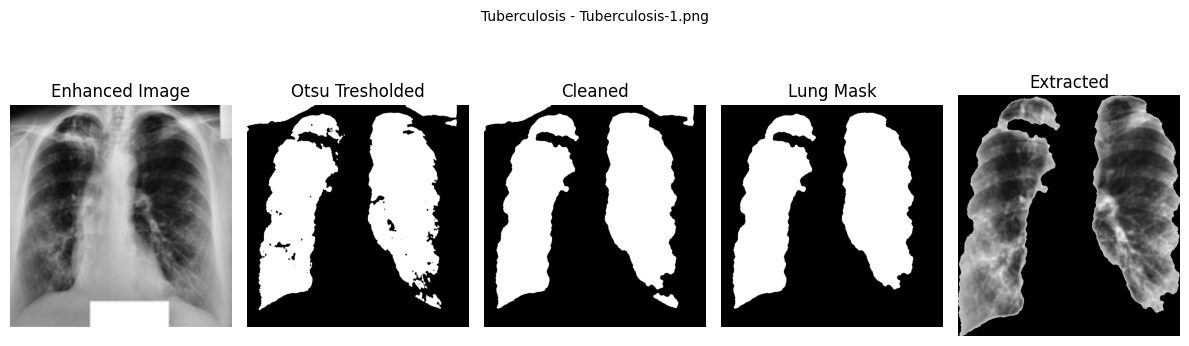

In [49]:
# Lung Region Segmentation

for category in categories:
    input_dir = os.path.join('./TB_Chest_Radiography_Database/enhanced_image', category)
    output_dir = os.path.join('./TB_Chest_Radiography_Database/segmented_image', category)
    os.makedirs(output_dir, exist_ok=True)

    files = [f for f in os.listdir(input_dir)]
    files.sort(key=lambda x: int(''.join(filter(str.isdigit, x))))  # urutin nomer

    for i, file in enumerate(files):
        img_path = os.path.join(input_dir, file)

        # 1. Read enhanced image and convert to grayscale
        img = cv2.imread(img_path)
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

        # 2. Otsu thresholding
        thresh_val = filters.threshold_otsu(gray)
        binary = gray > thresh_val
        binary = np.invert(binary)

        # 3. Mask Cleaning
        cleaned = morphology.closing(binary, morphology.disk(5)) # morphological opening and closing
        cleaned = morphology.opening(cleaned, morphology.disk(3))

        cleaned = morphology.remove_small_objects(cleaned, min_size=500) # remove small artifacts
        cleaned = morphology.remove_small_holes(cleaned, area_threshold=500)

        # 4. Lung Region Identification
        labels = measure.label(cleaned)
        lung_regions = measure.regionprops(labels)

        lung_regions = sorted(lung_regions, key=lambda x: x.area, reverse=True)[:2] # take the 2 biggest regions (likely to be left and right lungs)

        lung_mask = np.zeros_like(binary)
        for r in lung_regions:
            lung_mask[labels == r.label] = 1

        # 5. Lung Extraction
        extracted = gray * lung_mask.astype(np.uint8)

        coords = np.column_stack(np.where(lung_mask)) # crop to bounding box
        y_min, x_min = coords.min(axis=0)
        y_max, x_max = coords.max(axis=0)
        cropped = extracted[y_min:y_max, x_min:x_max]

        # Save gambar
        output_file = os.path.join(output_dir, file)
        cv2.imwrite(output_file, cropped)

        # Preview hasil

        preview_limit = 1 # limit preview
        if i < preview_limit:
            raw_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            titles = ['Enhanced Image', 'Otsu Tresholded', 'Cleaned', 'Lung Mask', 'Extracted']
            images = [img, binary, cleaned, lung_mask, cropped]

            plt.figure(figsize=(12, 4))
            for i in range(len(titles)):
                plt.subplot(1, len(titles), i + 1)
                plt.imshow(images[i], cmap='gray' if i > 0 else None)
                plt.title(titles[i])
                plt.axis('off')
            plt.suptitle(f"{category} - {file}", fontsize=10)
            plt.tight_layout()
            plt.show()